# Offline dataset test

In [1]:
import os
from keras.models import load_model
import pandas as pd
import numpy as np
import re
from PIL import  Image
from keras_preprocessing.image import img_to_array
from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import operator
import heapq

# Load the WiFi data

In [2]:
database = pd.read_pickle('C:/Users/user/OneDrive/CESI/work/Recherche/robotique/publication/IEEE Sensors Journal/shared code/WiFi data for training/data.pkl')

# GPR +WOA

In [3]:
df_mean = pd.read_pickle('C:/Users/user/OneDrive/CESI/work/Recherche/robotique/publication/IEEE Sensors Journal/shared code/WiFi data for training/data.pkl')
df_mean['Position_x'] = df_mean.Position.apply(lambda x: x[0])
df_mean['Position_y'] = df_mean.Position.apply(lambda x: x[1])
df_mean['Position_orientation'] = df_mean.Position.apply(lambda x: x[2])

df_mean = df_mean.drop(columns=['Unified Position','Position No.','Position'])


for c in df_mean.columns:
    if c != 'Label' and c != 'Position_x' and c != 'Position_y' and c != 'Position_orientation' :
        df_mean[c] = (df_mean[c]- df_mean[c].mean())/df_mean[c].std()



df_mean = df_mean.groupby(by=['Label']).mean()

df_mean = df_mean.reset_index()

AP= ['Address: 34:15:93:9C:D0:E0', 'Address: 34:15:93:5C:DE:C0',
       'Address: 34:15:93:5C:DE:C1', 'Address: 34:15:93:5C:AB:90',
       'Address: 34:15:93:5C:AB:91', 'Address: 34:15:93:5C:B0:60',
       'Address: 34:15:93:5C:7F:70', 'Address: 34:15:93:5C:B0:61',
       'Address: 34:15:93:5C:7F:71', 'Address: 34:15:93:5C:8B:61',
       'Address: 34:15:93:5C:D0:E0', 'Address: 34:15:93:5C:D0:E1',
       'Address: 34:15:93:9C:DE:C0', 'Address: 34:15:93:9C:DE:C1',
       'Address: 34:15:93:9C:D0:E1', 'Address: 34:15:93:9C:B0:60',
       'Address: 34:15:93:9C:B0:61', 'Address: 34:15:93:9C:8B:60',
       'Address: 34:15:93:9C:8B:61', 'Address: 34:15:93:9C:AB:90',
       'Address: 34:15:93:9C:AB:91', 'Address: 34:15:93:5C:D1:31',
       'Address: 34:15:93:5C:8B:60', 'Address: 34:15:93:5C:69:C0',
       'Address: 34:15:93:5C:69:C1', 'Address: 34:15:93:9C:7F:70',
       'Address: 34:15:93:9C:69:C0', 'Address: 34:15:93:9C:69:C1',
       'Address: 34:15:93:5C:D9:E0', 'Address: 34:15:93:9C:7F:71',
       'Address: 34:15:93:5C:FA:A1', 'Address: 34:15:93:5C:FA:A0',
       'Address: 34:15:93:5C:CA:11', 'Address: 34:15:93:5C:D9:E1',
       'Address: 34:15:93:5C:D1:30', 'Address: 34:15:93:5C:CA:10',
       'Address: 34:15:93:5C:C0:00', 'Address: 34:15:93:5C:C0:01',
       'Address: 34:15:93:5C:84:F1', 'Address: 34:15:93:5C:84:F0',
       'Address: 34:15:93:5C:D3:80', 'Address: 34:15:93:5C:D3:81',
       'Address: 34:15:93:5C:D3:50', 'Address: 34:15:93:5C:D3:51',
       'Address: 34:15:93:5C:BE:B1', 'Address: 34:15:93:5C:E8:50',
       'Address: 34:15:93:5C:E8:51', 'Address: 34:15:93:5C:BE:B0',
       'Address: 34:15:93:5C:D3:21', 'Address: 34:15:93:9C:C0:00',
       'Address: 34:15:93:9C:C0:01', 'Address: 34:15:93:5C:D3:20',
       'Address: 34:15:93:9C:FA:A1', 'Address: 34:15:93:9C:FA:A0',
       'Address: 3A:F6:E5:83:01:CE', 'Address: 1A:9C:69:C0:AC:CE',
       'Address: 34:15:93:9C:CA:10', 'Address: 34:15:93:9C:CA:11']


Position_sample = df_mean[['Position_x','Position_y']].values
REG = []


# Kernel function
kernel = C(1, (1e-6, 1)) * RBF(1, (1e-6, 1))

# Create Gaussian process regression  
for ap in AP: 
    reg = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha = 0.1)
    reg.fit(Position_sample, df_mean[ap])
    REG.append(reg)
    
    
    
    
import numpy as np
import matplotlib.pyplot as plt
 

# Objective function
def objective_function(X,RSSI):
  
    power_prediction=[]
    for k, ap in enumerate(AP): 
         power_prediction.append((REG[k].predict(X.reshape(1,-1), return_std=False)))
            
     
    return ((np.array(power_prediction).T - RSSI)**2).sum()
 
# WOA
class WhaleOptimizationAlgorithm:
    def __init__(self, objective, bounds, n_whales, n_iterations):
        self.objective = objective
        self.bounds = bounds
        self.n_whales = n_whales
        self.n_iterations = n_iterations
        self.dimension = len(bounds)
        self.X = np.zeros((self.n_whales, self.dimension))
        self.X_star = np.zeros(self.dimension)
        self.fitness_star = float('inf')
 
    def initialize(self):
        for i in range(self.n_whales):
            for j in range(self.dimension):
                self.X[i, j] = np.random.uniform(*self.bounds[j])
 
    def optimize(self,RSSI):
        for t in range(self.n_iterations):
            a = 2 - t * (2 / self.n_iterations)
            a2 = -1 + t * (-1 / self.n_iterations)
 
            for i in range(self.n_whales):
                r1 = np.random.rand()
                r2 = np.random.rand()
                A = 2 * a * r1 - a
                C = 2 * r2
                b = 1
                l = (a2 - 1) * np.random.rand() + 1
                p = np.random.rand()
 
                #for j in range(self.dimension):
                if p < 0.5:
                    if abs(A) >= 1: #  random searching
                        rand_leader_index = np.random.randint(0, self.n_whales)
                        X_rand = self.X[rand_leader_index, :]
                        D_X_rand = abs(C * X_rand - self.X[i, :])
                        self.X[i, :] = X_rand - A * D_X_rand
                    else:  # encircling prey
                        D_Leader = abs(C * self.X_star - self.X[i, :])
                        self.X[i, :] = self.X_star - A * D_Leader
                else:   # attack by Spiral bubbles
                    distance_to_Leader = abs(self.X_star - self.X[i, :])
                    self.X[i, :] = distance_to_Leader * np.exp(b * l) * np.cos(l * 2 * np.pi) + self.X_star
 
                fitness = self.objective(self.X[i, :],RSSI)
                if fitness < self.fitness_star:
                    self.fitness_star = fitness
                    self.X_star = self.X[i, :].copy()
        # data for visualization
        return self.X, self.X_star, self.fitness_star
 
# 设置参数
n_whales = 20  #  whales number
n_iterations = 100  #  number of iterations

bounds = [(-13, 3),(-18, 1)]

E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of

E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of

In [4]:
df_m = df_mean.copy()

In [5]:
df_m['Position'] = list(np.c_[np.array(df_m['Position_x']), np.array(df_m['Position_y']), df_m['Position_orientation']])
df_m['Position'] = df_m['Position'].apply(lambda x: list(x))

In [6]:
df_m = df_m.drop(columns=['Position_x','Position_y','Position_orientation','Label'])

In [7]:
df_m = df_m[['Position']+ AP]

# Create a distance table

In [8]:
distance = np.zeros([database.Label.nunique(),database.Label.nunique()])
for k in database.Label.unique():
    for kk in database.Label.unique():
        distance[k,kk] = np.sqrt((database[database.Label==k].Position.iloc[0][0]-database[database.Label==kk].Position.iloc[0][0])**2
                                +(database[database.Label==k].Position.iloc[0][1]-database[database.Label==kk].Position.iloc[0][1])**2)

# WKNN

In [9]:
neighbor_K = 4
    
##1. Function for computing Euclide distance
def euclideanDistance(instance1,instance2,length):
    dis0 = 0
    for i in range(0,length):
        dis0 += (instance1[i]-instance2[i])**2
    return dis0**0.5
##2.Computing the distance between the test point and reference points, taking the nearest K points
def getNeighbors(trainSet,testPoint,k):
    distance = []
    length = len(testPoint)-1
    for i in range(0,len(trainSet)):
        dis1 = euclideanDistance(testPoint[0::],trainSet[i,1::],length)
        distance.append((trainSet[i],dis1))
    distance_t = distance.copy()
    distance.sort(key = operator.itemgetter(1))      ## ranking
    neighbors = []
    for j in range(0,k):
        neighbors.append(distance[j])
    return neighbors, distance_t
##3. Weighting the K coordinates
def getResponse(neighbors):
    add_weight = 0

    crd = np.zeros([1,3])
    for i in range(0,len(neighbors)):
        add_weight += 1/neighbors[i][1] 
    for j in range(0,len(neighbors)):

          crd += (np.array(neighbors[j][0][0])/neighbors[j][1])/add_weight
    return crd
##4. accuracy function
def getAccuracy(pred_crd,test_crd):
    return np.mean(np.sqrt(np.sum((pred_crd-test_crd)**2,1)))

In [10]:
position_list = []
for label in database.Label.unique():
    position_list.append(np.array(database[database['Label'] ==label]['Position'].iloc[0][0:2]).reshape(1,-1))

position_list = np.array(position_list).reshape(43,2)

In [11]:
memori = 10
covar =True
fft = True

row = 58
colu = 58

Path_WiFi_5858 = "C:/Users/user/OneDrive/CESI/work/Recherche/robotique/publication/IEEE Sensors Journal/shared code/trained model/WiFi_5858_good.keras"
Path_Image_5858 = "C:/Users/user/OneDrive/CESI/work/Recherche/robotique/publication/IEEE Sensors Journal/shared code/trained model/Image_5858.keras"
Path_WiFi_Image_5858 = "C:/Users/user/OneDrive/CESI/work/Recherche/robotique/publication/IEEE Sensors Journal/shared code/trained model/WiFi_Image_5858_good.keras"


lenet_wifi_image = load_model(Path_WiFi_Image_5858)
lenet_wifi = load_model(Path_WiFi_5858)
lenet_image = load_model(Path_Image_5858)

    
folder_path = "C:/Users/user/OneDrive/CESI/work/Recherche/robotique/publication/IEEE Sensors Journal/shared code/test_database/"    
    
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

time_stamp = []

for fn in file_names:
    if len(fn)>10:
        time_stamp.append(fn[0:14])
        
time_stamp = np.unique(time_stamp) 

sample_list =[]
for ts in time_stamp:
    sample = {}
    for fn in file_names:
        if fn[0:21] == ts+'-image1':
            sample['image1'] = fn
            
        if fn[0:21] == ts+'-image2':
            sample['image2'] = fn
            
        if fn[0:21] == ts+'-image3':
            sample['image3'] = fn
            
        if fn[0:21] == ts+'-image4':
            sample['image4'] = fn
            
        if fn[0:19] == ts+'-wifi':
            sample['wifi'] = fn
            sample['position'] = fn[20:-4]
    sample_list.append(sample)         
            
            
test_dataset = pd.DataFrame(sample_list) 
test_dataset['position'] = test_dataset['position'].apply(lambda x: np.array(re.findall(r"[-+]?\d+\.?\d*[eE]?[-+]?\d*", x)))
test_dataset['position'] = test_dataset['position'].apply(lambda x:np.array([float(x[0]),float(x[1])]))

In [12]:
result_list = []
for k in range(test_dataset.shape[0]):
            print(test_dataset.iloc[k])
        
            result = {}   
        
            # visual features
            img = Image.open(folder_path+test_dataset.iloc[k]['image1'])
            img = img.resize((row, colu)) # change image size
            Xi = img_to_array(img)/255
            Xi = Xi.reshape(-1, row, colu, 3)
            Xi= Xi.astype('float32')     
            
 
            
            img = Image.open(folder_path+test_dataset.iloc[k]['image2'])
            img = img.resize((row, colu)) # change image size
            Xi1 = img_to_array(img)/255
            Xi1 = Xi1.reshape(-1, row, colu, 3)
            Xi1= Xi1.astype('float32')
            
            
            img = Image.open(folder_path+test_dataset.iloc[k]['image3'])
            img = img.resize((row, colu)) # change image size
            Xi2 = img_to_array(img)/255
            Xi2 = Xi2.reshape(-1, row, colu, 3)
            Xi2 = Xi2.astype('float32')
            
            img = Image.open(folder_path+test_dataset.iloc[k]['image4'])
            img = img.resize((row, colu)) # change image size
            Xi3 = img_to_array(img)/255
            Xi3 = Xi3.reshape(-1, row, colu, 3)
            Xi3 = Xi3.astype('float32')
            
            
            sample = pd.read_pickle(folder_path+test_dataset.iloc[k]['wifi'])
            
            print('saved sample:',sample)
            
############################################################################################################
            X = np.array(sample).reshape(-1,memori,sample.shape[1],1)

                    
##############

            X_e = np.zeros([X.shape[0],58,58,1])
            for k, x in enumerate(X):
                    for kk in range(5):
                        X_e[k,memori*kk:memori*(kk+1),0:X.shape[2],0]  = x[:,:,0]


                    X_e[k,memori*5::,0:X.shape[2],0]  = x[0:8,:,0] 
###################
    
    
    
            # Correlation feature
            if covar == True:
                    X_covar = np.zeros([X_e.shape[0],X_e.shape[2],X_e.shape[2],1])
                    for k, x in enumerate(X_e):
                        X_covar[k,:,:,0]  = x[:,:,0].T@x[:,:,0]
                        X_covar[k,:,:,0] = (X_covar[k,:,:,0]-X_covar[k,:,:,0].min())*255/(X_covar[k,:,:,0].max()-X_covar[k,:,:,0].min())

            # spectrum feature
            if fft == True:
                X_fft = np.zeros([X_e.shape[0],X_e.shape[1],X_e.shape[2],2])

                for k, x in enumerate(X_e):

                        f = np.fft.fft2(x[:,:,0])
                        fshift = np.fft.fftshift(f)

                                
                        X_fft[k,:,:,0] = (np.real(fshift)-np.real(fshift).min())*255/(np.real(fshift).max()-np.real(fshift).min())
                        X_fft[k,:,:,1] = (np.imag(fshift)-np.imag(fshift).min())*255/(np.imag(fshift).max()-np.imag(fshift).min())

##########################################
         
            
#####################################################
            # RSSI feature

            for c in sample.columns:
                 sample[c] = sample[c]*database[c].std()+database[c].mean() 

            
            print('recovered sample:',sample)
            Xt = np.array(sample).reshape(-1,memori,sample.shape[1],1)*255/70       

 
            for k, x in enumerate(Xt):
                    for kk in range(5):
                        X_e[k,memori*kk:memori*(kk+1),0:Xt.shape[2],0]  = x[:,:,0]

                    X_e[k,memori*5::,0:X.shape[2],0]  = x[0:8,:,0] 

#####################################################
        
        
        
            XX = np.zeros([X.shape[0],58,58,4])
            XX[:,0:X_e.shape[1],0:X_e.shape[2],0] = X_e[:,:,:,0]
            XX[:,0:X_e.shape[1],0:X_e.shape[2],1:3] =  X_fft            
            XX[:,0:X_e.shape[1],0:X_e.shape[2],3] =  X_covar[:,:,:,0]

            XX = XX/255
                
            X_all = np.zeros([X_e.shape[0],X_e.shape[2],X_e.shape[2],16])
            X_all[:,:,:,0:4]  = XX
            X_all[:,:,:,4:7] = Xi
            X_all[:,:,:,7:10] = Xi1
            X_all[:,:,:,10:13] = Xi2
            X_all[:,:,:,13::] = Xi3
            
          

            
            X_wifi_image =  X_all
            X_wifi =  X_all[:,:,:,0:4]
            
            
            
            XX_all = np.zeros([X_e.shape[0],X_e.shape[2],X_e.shape[2],12])
            XX_all[:,:,:,0:3]  = Xi
            XX_all[:,:,:,3:6]  = Xi1
            XX_all[:,:,:,6:9]  = Xi2
            XX_all[:,:,:,9::]  = Xi3
            
            X_image =  XX_all
############################################################################################################ 

            print('Computing')
            
            #############################################
            
            neighbors, WKNN_dis = getNeighbors(df_m.values, sample.values.mean(axis=0), neighbor_K)
            yy_pred_WKNN = getResponse(neighbors)[:,0:2]
            

            #############################################
            
            
            yy_pred_first_layer = lenet_wifi_image.predict(X_all)
   
           
            yy_pred_wifi = lenet_wifi.predict(X_wifi)
        
            yy_pred_image = lenet_image.predict(X_image)            

            
            yy_pred_double_layer = yy_pred_first_layer*yy_pred_wifi*yy_pred_image
            yy_pred_double_layer = yy_pred_double_layer**(1.0/3.0)
            
               
            
            ################################
            yy_pred_double_layer = yy_pred_double_layer/yy_pred_double_layer.sum() 
            
           
            K_best = 4
            gamma = np.array(heapq.nlargest(K_best,yy_pred_double_layer.reshape(-1))).min()
           
            while (gamma==0):
                K_best = K_best - 1
                gamma = np.array(heapq.nlargest(K_best,yy_pred_double_layer.reshape(-1))).min()
               
               
            mask = (yy_pred_double_layer >= gamma).astype('int')*yy_pred_double_layer
           
            yy_pred_double_layer = mask@position_list/mask.sum()


            ########################################

            Label_pred_first_layer =[np.where(t == t.max())[0][0] for t in yy_pred_first_layer][0]
            yy_pred_first_layer = np.array(database[database['Label'] ==Label_pred_first_layer]['Position'].iloc[0][0:2]).reshape(1,-1)

#########################################################################            
            K_best = 4
            gamma = np.array(heapq.nlargest(K_best,yy_pred_wifi.reshape(-1))).min()
           
            while (gamma==0):
                K_best = K_best - 1
                gamma = np.array(heapq.nlargest(K_best,yy_pred_wifi.reshape(-1))).min()
               
               
            mask = (yy_pred_wifi >= gamma).astype('int')*yy_pred_wifi
           
            yy_pred_wifi = mask@position_list/mask.sum()        
        
#########################################################################
            
#########################################################################            
            K_best = 4
            gamma = np.array(heapq.nlargest(K_best,yy_pred_image.reshape(-1))).min()
           
            while (gamma==0):
                K_best = K_best - 1
                gamma = np.array(heapq.nlargest(K_best,yy_pred_image.reshape(-1))).min()
               
               
            mask = (yy_pred_image >= gamma).astype('int')*yy_pred_image
           
            yy_pred_image = mask@position_list/mask.sum()        
        
#########################################################################
            

             
            ###################################################################
                # WOA
            woa = WhaleOptimizationAlgorithm(objective_function, bounds, n_whales, n_iterations)
            woa.initialize()
            
            whales, best_whale, best_fitness = woa.optimize(RSSI = sample.values.mean(axis=0))
            
            yy_pred_WOA = best_whale.reshape(1,-1)
####################################################################### 
            
            result['WiFi'] = yy_pred_wifi
        
            result['First_layer'] = yy_pred_first_layer
            
 
            
            result['Double_layer'] = yy_pred_double_layer
            

            
            result['Image'] = yy_pred_image
            
            result['WKNN'] =  yy_pred_WKNN
            
            result['WOA'] =   yy_pred_WOA
            
            result_list.append(result)         

result_list = pd.DataFrame(result_list) 
result_list['True position'] = test_dataset['position']
result_list['True position'] = result_list['True position'].apply(lambda x: x.reshape(1,-1))

image1      20240930152712-image1-[-0.17733072 -0.63474969...
image2      20240930152712-image2-[-0.17733072 -0.63474969...
image3      20240930152712-image3-[-0.17733072 -0.63474969...
image4      20240930152712-image4-[-0.17733072 -0.63474969...
wifi        20240930152712-wifi-[-0.17733072 -0.63474969 5...
position                           [-0.17733072, -0.63474969]
Name: 0, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -3.931333                    0.567127   
1                   -3.931333                   -0.305151   
2                   -3.931333                   -0.305151   
3                   -3.931333                   -0.305151   
4                   -3.931333                    0.179448   
5                   -3.931333                    0.179448   
6                   -2.001004                    0.179448   
7                   -2.001004                   -0.305151   
8                   -2.001004             

1/1 [==============================] - 0s 115ms/step
image1      20240930153053-image1-[-0.22739151 -0.62798392...
image2      20240930153053-image2-[-0.22739151 -0.62798392...
image3      20240930153053-image3-[-0.22739151 -0.62798392...
image4      20240930153053-image4-[-0.22739151 -0.62798392...
wifi        20240930153053-wifi-[-0.22739151 -0.62798392 8...
position                           [-0.22739151, -0.62798392]
Name: 1, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.276766                    0.179448   
1                   -2.276766                    0.179448   
2                   -2.276766                    0.179448   
3                   -2.276766                    0.082528   
4                   -2.276766                    0.276368   
5                   -2.276766                    0.276368   
6                   -2.276766                    0.276368   
7                   -2.276766                    0

1/1 [==============================] - 0s 31ms/step
image1      20240930153638-image1-[-1.61738972e+00  8.3003...
image2      20240930153638-image2-[-1.61738972e+00  8.3003...
image3      20240930153638-image3-[-1.61738972e+00  8.3003...
image4      20240930153638-image4-[-1.61738972e+00  8.3003...
wifi        20240930153638-wifi-[-1.61738972e+00 8.3003481...
position                          [-1.61738972, 0.0830034816]
Name: 2, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.001004                    0.276368   
1                   -2.001004                   -0.111312   
2                   -2.184845                    0.276368   
3                   -2.184845                    0.276368   
4                   -2.092925                    0.373288   
5                   -2.092925                   -0.208232   
6                   -2.092925                    0.276368   
7                   -2.092925                   -0.

1/1 [==============================] - 0s 31ms/step
image1      20240930153906-image1-[  -2.73269839   -0.2013...
image2      20240930153906-image2-[  -2.73269839   -0.2013...
image3      20240930153906-image3-[  -2.73269839   -0.2013...
image4      20240930153906-image4-[  -2.73269839   -0.2013...
wifi        20240930153906-wifi-[  -2.73269839   -0.201301...
position                           [-2.73269839, -0.20130173]
Name: 3, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.184845                    1.148646   
1                   -1.817163                    0.954807   
2                   -2.001004                    0.760967   
3                   -1.909084                    0.760967   
4                   -1.909084                    0.760967   
5                   -1.725243                    0.664047   
6                   -1.909084                    0.664047   
7                   -1.725243                    0.

1/1 [==============================] - 0s 16ms/step
image1      20240930154144-image1-[-2.76109033e+00 -8.0689...
image2      20240930154144-image2-[-2.76109033e+00 -8.0689...
image3      20240930154144-image3-[-2.76109033e+00 -8.0689...
image4      20240930154144-image4-[-2.76109033e+00 -8.0689...
wifi        20240930154144-wifi-[-2.76109033e+00 -8.068969...
position                         [-2.76109033, -0.0806896996]
Name: 4, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.909084                    0.567127   
1                   -1.909084                   -0.208232   
2                   -1.817163                    0.470207   
3                   -1.817163                   -0.595911   
4                   -1.909084                    0.567127   
5                   -1.909084                   -0.305151   
6                   -1.633322                    0.567127   
7                   -2.001004                   -0.

1/1 [==============================] - 0s 31ms/step
image1      20240930154630-image1-[ -2.73839842  -0.108893...
image2      20240930154630-image2-[ -2.73839842  -0.108893...
image3      20240930154630-image3-[ -2.73839842  -0.108893...
image4      20240930154630-image4-[ -2.73839842  -0.108893...
wifi        20240930154630-wifi-[ -2.73839842  -0.10889336...
position                           [-2.73839842, -0.10889336]
Name: 5, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.909084                    0.857887   
1                   -1.909084                    0.179448   
2                   -1.909084                    0.857887   
3                   -1.909084                    0.082528   
4                   -2.092925                    0.954807   
5                   -2.092925                    0.082528   
6                   -2.001004                    0.082528   
7                   -2.001004                    0.

1/1 [==============================] - 0s 26ms/step
image1      20240930154839-image1-[ -2.73978275  -0.157647...
image2      20240930154839-image2-[ -2.73978275  -0.157647...
image3      20240930154839-image3-[ -2.73978275  -0.157647...
image4      20240930154839-image4-[ -2.73978275  -0.157647...
wifi        20240930154839-wifi-[ -2.73978275  -0.15764795...
position                           [-2.73978275, -0.15764795]
Name: 6, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.092925                   -0.111312   
1                   -2.276766                    0.470207   
2                   -2.001004                    0.082528   
3                   -2.092925                    0.664047   
4                   -2.001004                    0.276368   
5                   -2.001004                    0.664047   
6                   -2.092925                   -0.014392   
7                   -1.909084                    0.

1/1 [==============================] - 0s 25ms/step
image1      20240930155433-image1-[ -1.93464912  -1.460930...
image2      20240930155433-image2-[ -1.93464912  -1.460930...
image3      20240930155433-image3-[ -1.93464912  -1.460930...
image4      20240930155433-image4-[ -1.93464912  -1.460930...
wifi        20240930155433-wifi-[ -1.93464912  -1.46093081...
position                           [-1.93464912, -1.46093081]
Name: 7, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.909084                    0.179448   
1                   -1.817163                    0.179448   
2                   -1.725243                    0.082528   
3                   -2.001004                    0.373288   
4                   -1.725243                    0.857887   
5                   -2.092925                    0.567127   
6                   -1.633322                    0.664047   
7                   -1.633322                    0.

1/1 [==============================] - 0s 26ms/step
image1      20240930155856-image1-[-1.96278371 -1.37567645...
image2      20240930155856-image2-[-1.96278371 -1.37567645...
image3      20240930155856-image3-[-1.96278371 -1.37567645...
image4      20240930155856-image4-[-1.96278371 -1.37567645...
wifi        20240930155856-wifi-[-1.96278371 -1.37567645  ...
position                           [-1.96278371, -1.37567645]
Name: 8, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.001004                    0.954807   
1                   -1.817163                    0.470207   
2                   -2.276766                    1.051727   
3                   -1.817163                    0.373288   
4                   -2.001004                    1.051727   
5                   -1.725243                    0.276368   
6                   -2.184845                    0.954807   
7                   -1.909084                    0.

1/1 [==============================] - 0s 25ms/step
image1      20240930160115-image1-[ -1.14125107  -2.711749...
image2      20240930160115-image2-[ -1.14125107  -2.711749...
image3      20240930160115-image3-[ -1.14125107  -2.711749...
image4      20240930160115-image4-[ -1.14125107  -2.711749...
wifi        20240930160115-wifi-[ -1.14125107  -2.71174917...
position                           [-1.14125107, -2.71174917]
Name: 9, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.184845                    0.954807   
1                   -1.449482                   -0.208232   
2                   -1.449482                    1.148646   
3                   -1.541402                   -0.305151   
4                   -2.001004                    1.148646   
5                   -1.725243                   -0.208232   
6                   -1.725243                    1.148646   
7                   -1.817163                    0.

1/1 [==============================] - 0s 27ms/step
image1      20240930160353-image1-[-1.12744903 -2.75050243...
image2      20240930160353-image2-[-1.12744903 -2.75050243...
image3      20240930160353-image3-[-1.12744903 -2.75050243...
image4      20240930160353-image4-[-1.12744903 -2.75050243...
wifi        20240930160353-wifi-[-1.12744903 -2.75050243  ...
position                           [-1.12744903, -2.75050243]
Name: 10, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.001004                    1.245566   
1                   -1.909084                    0.179448   
2                   -2.092925                    1.342486   
3                   -1.909084                    0.179448   
4                   -2.092925                    1.148646   
5                   -1.909084                   -0.014392   
6                   -1.909084                    1.148646   
7                   -2.001004                    0

1/1 [==============================] - 0s 24ms/step
image1      20240930160605-image1-[-1.09377443 -2.78500147...
image2      20240930160605-image2-[-1.09377443 -2.78500147...
image3      20240930160605-image3-[-1.09377443 -2.78500147...
image4      20240930160605-image4-[-1.09377443 -2.78500147...
wifi        20240930160605-wifi-[-1.09377443 -2.78500147 3...
position                           [-1.09377443, -2.78500147]
Name: 11, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -2.001004                   -0.498991   
1                   -1.541402                    0.857887   
2                   -1.817163                   -0.305151   
3                   -2.001004                    1.051727   
4                   -1.725243                   -0.014392   
5                   -1.909084                    1.051727   
6                   -1.909084                    0.082528   
7                   -1.909084                    1

1/1 [==============================] - 0s 26ms/step
image1      20240930161146-image1-[-0.18578942 -4.36487634...
image2      20240930161146-image2-[-0.18578942 -4.36487634...
image3      20240930161146-image3-[-0.18578942 -4.36487634...
image4      20240930161146-image4-[-0.18578942 -4.36487634...
wifi        20240930161146-wifi-[-0.18578942 -4.36487634 1...
position                           [-0.18578942, -4.36487634]
Name: 12, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.449482                    1.439406   
1                   -1.909084                    1.342486   
2                   -1.909084                    1.439406   
3                   -1.725243                    0.470207   
4                   -1.449482                    1.439406   
5                   -2.092925                    0.664047   
6                   -1.357561                    1.439406   
7                   -1.725243                    0

1/1 [==============================] - 0s 27ms/step
image1      20240930162736-image1-[ -1.42318754  -5.041521...
image2      20240930162736-image2-[ -1.42318754  -5.041521...
image3      20240930162736-image3-[ -1.42318754  -5.041521...
image4      20240930162736-image4-[ -1.42318754  -5.041521...
wifi        20240930162736-wifi-[ -1.42318754  -5.04152155...
position                           [-1.42318754, -5.04152155]
Name: 13, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.541402                    0.954807   
1                   -1.541402                    0.373288   
2                   -1.725243                    0.954807   
3                   -1.541402                    0.373288   
4                   -1.725243                    0.954807   
5                   -1.449482                    0.470207   
6                   -1.725243                    0.567127   
7                   -1.541402                    0

1/1 [==============================] - 0s 31ms/step
image1      20240930162915-image1-[ -1.45029379  -4.963517...
image2      20240930162915-image2-[ -1.45029379  -4.963517...
image3      20240930162915-image3-[ -1.45029379  -4.963517...
image4      20240930162915-image4-[ -1.45029379  -4.963517...
wifi        20240930162915-wifi-[ -1.45029379  -4.96351727...
position                           [-1.45029379, -4.96351727]
Name: 14, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.449482                    0.857887   
1                   -1.449482                    0.276368   
2                   -1.449482                    0.760967   
3                   -1.449482                    0.276368   
4                   -1.357561                    0.760967   
5                   -1.357561                    0.373288   
6                   -1.541402                    0.857887   
7                   -1.357561                    0

1/1 [==============================] - 0s 31ms/step
image1      20240930163049-image1-[ -1.39731611  -4.941713...
image2      20240930163049-image2-[ -1.39731611  -4.941713...
image3      20240930163049-image3-[ -1.39731611  -4.941713...
image4      20240930163049-image4-[ -1.39731611  -4.941713...
wifi        20240930163049-wifi-[ -1.39731611  -4.94171373...
position                           [-1.39731611, -4.94171373]
Name: 15, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.725243                    0.276368   
1                   -1.541402                    0.373288   
2                   -1.725243                    0.179448   
3                   -1.449482                    0.082528   
4                   -1.633322                    0.276368   
5                   -1.449482                    0.276368   
6                   -1.357561                    0.179448   
7                   -1.541402                    0

1/1 [==============================] - 0s 33ms/step
image1      20240930163235-image1-[-1.39408023 -4.97443535...
image2      20240930163235-image2-[-1.39408023 -4.97443535...
image3      20240930163235-image3-[-1.39408023 -4.97443535...
image4      20240930163235-image4-[-1.39408023 -4.97443535...
wifi        20240930163235-wifi-[-1.39408023 -4.97443535 1...
position                           [-1.39408023, -4.97443535]
Name: 16, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.817163                    0.276368   
1                   -1.449482                    0.760967   
2                   -1.817163                    0.082528   
3                   -1.541402                    0.760967   
4                   -1.817163                    0.179448   
5                   -1.817163                    0.664047   
6                   -1.817163                    0.082528   
7                   -1.633322                    0

1/1 [==============================] - 0s 30ms/step
image1      20240930163523-image1-[  -2.80235044   -6.4488...
image2      20240930163523-image2-[  -2.80235044   -6.4488...
image3      20240930163523-image3-[  -2.80235044   -6.4488...
image4      20240930163523-image4-[  -2.80235044   -6.4488...
wifi        20240930163523-wifi-[  -2.80235044   -6.448832...
position                           [-2.80235044, -6.44883286]
Name: 17, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.357561                    0.470207   
1                   -0.806039                    0.857887   
2                   -1.449482                    0.470207   
3                   -0.897959                    0.567127   
4                   -0.897959                   -0.014392   
5                   -0.897959                   -0.111312   
6                   -0.897959                   -0.014392   
7                   -0.806039                    0

1/1 [==============================] - 0s 31ms/step
image1      20240930163853-image1-[ -2.87582389  -6.466956...
image2      20240930163853-image2-[ -2.87582389  -6.466956...
image3      20240930163853-image3-[ -2.87582389  -6.466956...
image4      20240930163853-image4-[ -2.87582389  -6.466956...
wifi        20240930163853-wifi-[ -2.87582389  -6.46695689...
position                           [-2.87582389, -6.46695689]
Name: 18, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -1.633322                    1.051727   
1                   -0.897959                    0.082528   
2                   -1.633322                    0.857887   
3                   -1.081800                   -0.111312   
4                   -1.633322                    0.857887   
5                   -1.173720                   -0.014392   
6                   -1.541402                    1.051727   
7                   -1.173720                   -0

1/1 [==============================] - 0s 35ms/step
image1      20240930164129-image1-[  -4.68328079   -7.2530...
image2      20240930164129-image2-[  -4.68328079   -7.2530...
image3      20240930164129-image3-[  -4.68328079   -7.2530...
image4      20240930164129-image4-[  -4.68328079   -7.2530...
wifi        20240930164129-wifi-[  -4.68328079   -7.253081...
position                           [-4.68328079, -7.25308184]
Name: 19, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.806039                   -0.498991   
1                   -1.173720                   -0.498991   
2                   -0.897959                   -0.208232   
3                   -1.081800                   -0.014392   
4                   -0.622198                   -0.208232   
5                   -1.173720                   -0.208232   
6                   -0.806039                   -0.208232   
7                   -1.357561                   -0

1/1 [==============================] - 0s 31ms/step
image1      20240930164324-image1-[ -4.59553229  -7.243380...
image2      20240930164324-image2-[ -4.59553229  -7.243380...
image3      20240930164324-image3-[ -4.59553229  -7.243380...
image4      20240930164324-image4-[ -4.59553229  -7.243380...
wifi        20240930164324-wifi-[ -4.59553229  -7.24338058...
position                           [-4.59553229, -7.24338058]
Name: 20, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.622198                   -1.274350   
1                   -0.714118                    0.567127   
2                   -0.530277                    0.567127   
3                   -0.622198                   -0.111312   
4                   -0.622198                   -1.177430   
5                   -0.530277                    0.082528   
6                   -0.622198                   -0.402071   
7                   -0.346436                   -0

1/1 [==============================] - 0s 34ms/step
image1      20240930164630-image1-[  -7.35373823   -8.8432...
image2      20240930164630-image2-[  -7.35373823   -8.8432...
image3      20240930164630-image3-[  -7.35373823   -8.8432...
image4      20240930164630-image4-[  -7.35373823   -8.8432...
wifi        20240930164630-wifi-[  -7.35373823   -8.843231...
position                            [-7.35373823, -8.8432312]
Name: 21, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.254516                   -0.402071   
1                   -0.254516                    0.082528   
2                    0.113166                   -0.208232   
3                   -0.530277                   -0.014392   
4                   -0.530277                   -0.305151   
5                   -0.438357                    0.276368   
6                   -0.254516                    0.082528   
7                   -0.254516                    0

1/1 [==============================] - 0s 34ms/step
image1      20240930165321-image1-[-7.29872388 -8.8498624 ...
image2      20240930165321-image2-[-7.29872388 -8.8498624 ...
image3      20240930165321-image3-[-7.29872388 -8.8498624 ...
image4      20240930165321-image4-[-7.29872388 -8.8498624 ...
wifi        20240930165321-wifi-[-7.29872388 -8.8498624  -...
position                            [-7.29872388, -8.8498624]
Name: 22, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.254516                   -0.886671   
1                   -0.346436                   -0.886671   
2                   -0.254516                   -0.692831   
3                   -0.438357                   -0.886671   
4                   -0.346436                   -0.595911   
5                   -0.346436                   -0.886671   
6                   -0.346436                   -0.886671   
7                   -0.346436                   -0

1/1 [==============================] - 0s 16ms/step
image1      20240930165640-image1-[-7.27457724 -8.853036  ...
image2      20240930165640-image2-[-7.27457724 -8.853036  ...
image3      20240930165640-image3-[-7.27457724 -8.853036  ...
image4      20240930165640-image4-[-7.27457724 -8.853036  ...
wifi        20240930165640-wifi-[-7.27457724 -8.853036   2...
position                             [-7.27457724, -8.853036]
Name: 23, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.622198                   -3.988106   
1                   -0.162595                   -3.988106   
2                   -0.714118                    0.082528   
3                   -0.070675                    0.082528   
4                   -0.806039                   -0.498991   
5                   -0.346436                   -1.274350   
6                   -0.806039                   -0.692831   
7                   -0.254516                   -1

1/1 [==============================] - 0s 26ms/step
image1      20240930170307-image1-[ -5.17664445  -9.819792...
image2      20240930170307-image2-[ -5.17664445  -9.819792...
image3      20240930170307-image3-[ -5.17664445  -9.819792...
image4      20240930170307-image4-[ -5.17664445  -9.819792...
wifi        20240930170307-wifi-[ -5.17664445  -9.81979276...
position                           [-5.17664445, -9.81979276]
Name: 24, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.021245                   -0.595911   
1                    0.480848                    0.276368   
2                    0.113166                   -0.402071   
3                    0.572768                   -0.111312   
4                    0.113166                   -0.111312   
5                    0.572768                    0.179448   
6                    0.113166                    0.179448   
7                    0.572768                    0

1/1 [==============================] - 0s 27ms/step
image1      20240930170513-image1-[-5.19448929 -9.80160824...
image2      20240930170513-image2-[-5.19448929 -9.80160824...
image3      20240930170513-image3-[-5.19448929 -9.80160824...
image4      20240930170513-image4-[-5.19448929 -9.80160824...
wifi        20240930170513-wifi-[-5.19448929 -9.80160824  ...
position                           [-5.19448929, -9.80160824]
Name: 25, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.664689                   -0.692831   
1                    0.480848                   -0.498991   
2                    0.664689                    0.276368   
3                    0.388927                    0.276368   
4                    0.664689                    0.276368   
5                    0.388927                    0.276368   
6                    0.664689                    0.276368   
7                    0.388927                   -0

1/1 [==============================] - 0s 31ms/step
image1      20240930170719-image1-[-5.16851241 -9.84108229...
image2      20240930170719-image2-[-5.16851241 -9.84108229...
image3      20240930170719-image3-[-5.16851241 -9.84108229...
image4      20240930170719-image4-[-5.16851241 -9.84108229...
wifi        20240930170719-wifi-[-5.16851241 -9.84108229 3...
position                           [-5.16851241, -9.84108229]
Name: 26, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.438357                   -0.402071   
1                    0.205086                    0.179448   
2                   -0.622198                    0.179448   
3                   -0.070675                    0.179448   
4                   -0.438357                   -0.305151   
5                    0.021245                    0.082528   
6                   -0.438357                   -0.402071   
7                    0.021245                    0

1/1 [==============================] - 0s 25ms/step
image1      20240930170913-image1-[-5.1807072  -9.80800498...
image2      20240930170913-image2-[-5.1807072  -9.80800498...
image3      20240930170913-image3-[-5.1807072  -9.80800498...
image4      20240930170913-image4-[-5.1807072  -9.80800498...
wifi        20240930170913-wifi-[-5.1807072  -9.80800498 6...
position                            [-5.1807072, -9.80800498]
Name: 27, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.480848                   -0.111312   
1                    0.756609                    0.470207   
2                    0.480848                   -0.402071   
3                    0.756609                    0.179448   
4                    0.572768                   -0.208232   
5                    0.756609                    0.179448   
6                    0.572768                   -0.402071   
7                    0.664689                   -0

1/1 [==============================] - 0s 24ms/step
image1      20240930171150-image1-[ -4.53586345 -10.967525...
image2      20240930171150-image2-[ -4.53586345 -10.967525...
image3      20240930171150-image3-[ -4.53586345 -10.967525...
image4      20240930171150-image4-[ -4.53586345 -10.967525...
wifi        20240930171150-wifi-[ -4.53586345 -10.96752569...
position                          [-4.53586345, -10.96752569]
Name: 28, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.021245                    0.373288   
1                    0.205086                    0.179448   
2                    0.113166                    0.373288   
3                   -0.070675                   -0.014392   
4                   -0.070675                    0.179448   
5                    0.021245                    0.082528   
6                    0.021245                    0.276368   
7                    0.113166                    0

1/1 [==============================] - 0s 23ms/step
image1      20240930171425-image1-[ -4.55049053 -10.949778...
image2      20240930171425-image2-[ -4.55049053 -10.949778...
image3      20240930171425-image3-[ -4.55049053 -10.949778...
image4      20240930171425-image4-[ -4.55049053 -10.949778...
wifi        20240930171425-wifi-[ -4.55049053 -10.94977865...
position                          [-4.55049053, -10.94977865]
Name: 29, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                   -0.070675                   -0.014392   
1                    0.756609                   -0.692831   
2                    0.021245                   -0.111312   
3                    0.756609                   -0.983591   
4                   -0.070675                    0.276368   
5                    0.664689                   -0.498991   
6                    0.021245                   -0.014392   
7                    0.756609                   -0

1/1 [==============================] - 0s 25ms/step
image1      20240930171757-image1-[ -3.42604789 -12.712873...
image2      20240930171757-image2-[ -3.42604789 -12.712873...
image3      20240930171757-image3-[ -3.42604789 -12.712873...
image4      20240930171757-image4-[ -3.42604789 -12.712873...
wifi        20240930171757-wifi-[ -3.42604789 -12.71287328...
position                          [-3.42604789, -12.71287328]
Name: 30, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.848529                    0.082528   
1                    0.664689                    0.082528   
2                    0.664689                    0.082528   
3                    0.664689                    0.082528   
4                    0.664689                    0.373288   
5                    0.664689                    0.373288   
6                    0.297007                    0.276368   
7                    0.756609                    0

1/1 [==============================] - 0s 22ms/step
image1      20240930172017-image1-[ -3.46964942 -12.659336...
image2      20240930172017-image2-[ -3.46964942 -12.659336...
image3      20240930172017-image3-[ -3.46964942 -12.659336...
image4      20240930172017-image4-[ -3.46964942 -12.659336...
wifi        20240930172017-wifi-[ -3.46964942 -12.65933604...
position                          [-3.46964942, -12.65933604]
Name: 31, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.388927                   -0.402071   
1                    0.297007                    0.179448   
2                    0.297007                   -0.014392   
3                    0.297007                   -0.305151   
4                    0.388927                    0.082528   
5                    0.297007                    0.373288   
6                    0.113166                   -0.305151   
7                    0.388927                    0

1/1 [==============================] - 0s 18ms/step
image1      20240930172308-image1-[ -2.00582494 -14.761394...
image2      20240930172308-image2-[ -2.00582494 -14.761394...
image3      20240930172308-image3-[ -2.00582494 -14.761394...
image4      20240930172308-image4-[ -2.00582494 -14.761394...
wifi        20240930172308-wifi-[ -2.00582494 -14.76139446...
position                          [-2.00582494, -14.76139446]
Name: 32, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    1.032370                    1.827086   
1                    0.940450                    0.760967   
2                    0.940450                    1.730166   
3                    1.032370                    0.470207   
4                    1.032370                    1.924005   
5                    1.032370                    0.760967   
6                    1.124291                    1.827086   
7                    0.940450                    0

1/1 [==============================] - 0s 17ms/step
image1      20240930172833-image1-[  -7.46002893   -6.8853...
image2      20240930172833-image2-[  -7.46002893   -6.8853...
image3      20240930172833-image3-[  -7.46002893   -6.8853...
image4      20240930172833-image4-[  -7.46002893   -6.8853...
wifi        20240930172833-wifi-[  -7.46002893   -6.885383...
position                           [-7.46002893, -6.88538319]
Name: 33, dtype: object
saved sample:    Address: 34:15:93:9C:D0:E0  Address: 34:15:93:5C:DE:C0  \
0                    0.113166                   -0.789751   
1                   -0.070675                   -0.595911   
2                    0.021245                   -0.498991   
3                    0.021245                   -0.402071   
4                    0.021245                   -0.595911   
5                   -0.070675                   -0.692831   
6                   -0.070675                   -0.595911   
7                   -0.070675                   -0

1/1 [==============================] - 0s 25ms/step


# Error distance

In [13]:
result_list['WiFi_error_distance'] = (result_list['WiFi']-result_list['True position']).apply(lambda x: np.sqrt((x**2).sum()))
result_list['First_layer_error_distance'] = (result_list['First_layer']-result_list['True position']).apply(lambda x: np.sqrt((x**2).sum()))

result_list['Double_layer_error_distance'] = (result_list['Double_layer']-result_list['True position']).apply(lambda x: np.sqrt((x**2).sum()))

result_list['Image_error_distance'] = (result_list['Image']-result_list['True position']).apply(lambda x: np.sqrt((x**2).sum()))
result_list['WKNN_error_distance'] = (result_list['WKNN']-result_list['True position']).apply(lambda x: np.sqrt((x**2).sum()))
result_list['WOA_error_distance'] = (result_list['WOA']-result_list['True position']).apply(lambda x: np.sqrt((x**2).sum()))

# RMSE

In [14]:
result_list['First_layer_RMSE'] = np.sqrt((result_list['First_layer']-result_list['True position']).apply(lambda x: ((x**2).sum())).mean())
result_list['Double_layer_RMSE'] = np.sqrt((result_list['Double_layer']-result_list['True position']).apply(lambda x: ((x**2).sum())).mean())
result_list['WiFi_RMSE'] =  np.sqrt((result_list['WiFi']-result_list['True position']).apply(lambda x: ((x**2).sum())).mean())
result_list['Image_RMSE'] = np.sqrt((result_list['Image']-result_list['True position']).apply(lambda x: ((x**2).sum())).mean())
result_list['WOA_RMSE'] = np.sqrt((result_list['WOA']-result_list['True position']).apply(lambda x: ((x**2).sum())).mean())
result_list['WKNN_RMSE'] = np.sqrt((result_list['WKNN']-result_list['True position']).apply(lambda x: ((x**2).sum())).mean())

In [15]:
result_list

,WiFi,First_layer,Double_layer,Image,WKNN,WOA,True position,WiFi_error_distance,First_layer_error_distance,Double_layer_error_distance,Image_error_distance,WKNN_error_distance,WOA_error_distance,First_layer_RMSE,Double_layer_RMSE,WiFi_RMSE,Image_RMSE,WOA_RMSE,WKNN_RMSE
0,"[[-0.06276975206204859, -0.38977076791185256]]","[[-2.5282114594727547, -0.343704390284131]]","[[-1.1442980331140438, -0.6628616904269364]]","[[-1.4732501520876584, -2.9376341277403237]]","[[-1.5496673161514094, -1.9272995942365563]]","[[-1.8652380343720827, -1.4558445299506184]]","[[-0.17733072, -0.63474969]]",0.270442,2.368828,0.967376,2.642477,1.885204,1.877026,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
1,"[[0.09022067078752917, -0.4289057091819945]]","[[0.21462852087414452, -0.39438422543058554]]","[[-0.16598297293552208, -0.4043162071421261]]","[[-0.9680799319710582, -1.2531729484086864]]","[[-1.5493955989403188, -1.9277506362656909]]","[[-0.46750216454703725, -4.287862684936757]]","[[-0.22739151, -0.62798392]]",0.374846,0.499951,0.231945,0.969268,1.853939,3.667747,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
2,"[[-0.4854897246578676, -0.7750379171683198]]","[[-1.1368471491877252, 0.16122163378768706]]","[[-2.6060787094001876, -1.3093304902025744]]","[[-0.5681546193421831, -13.75780839177188]]","[[-1.5486033163228077, -1.9292332184504135]]","[[-0.5919665589252491, -4.185392406266448]]","[[-1.61738972, 0.0830034816]]",1.420364,0.486867,1.707659,13.880525,2.013412,4.389840,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
3,"[[-2.238985076362725, -0.5564024001908051]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.307335465281698, -0.44487053280828187]]","[[-2.2584606255091275, -0.9338580194129605]]","[[-1.5493179959844434, -1.9279974731121094]]","[[-1.9165838115202405, -1.3487165602807472]]","[[-2.73269839, -0.20130173]]",0.608152,0.249186,0.490163,0.872663,2.093291,1.408050,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
4,"[[-1.406726986202421, -0.9610116507864294]]","[[-2.5282114594727547, -0.343704390284131]]","[[-1.8803975043361163, -1.211148393699873]]","[[-0.7764017804728007, -3.0378170753581966]]","[[-1.5493225063955602, -1.928024367433463]]","[[-1.8603962497007642, -1.439104993491757]]","[[-2.76109033, -0.0806896996]]",1.615323,0.351297,1.433024,3.561403,2.209305,1.629890,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
5,"[[-0.35831498676228263, -0.6208798036036488]]","[[-1.5919821419635822, -5.22474917215175]]","[[-1.5680322684383408, -1.889841307972495]]","[[-1.0984689152689162, -3.3100596791972885]]","[[-1.548982181765919, -1.9286528805188163]]","[[-0.47836855876176293, -4.251938963025957]]","[[-2.73839842, -0.10889336]]",2.434528,5.242733,2.131087,3.596781,2.173991,4.719382,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
6,"[[-2.401452624454995, -0.41941832460957135]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.394186244292657, -0.37532018612593265]]","[[-2.0485373806727574, -2.456214591835037]]","[[-1.5494083319732925, -1.9278945336834472]]","[[-1.8305890555943771, -1.6383481826232837]]","[[-2.73978275, -0.15764795]]",0.427774,0.281744,0.408434,2.400256,2.133252,1.737558,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
7,"[[-2.220319187065173, -0.7862995628680198]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.039241268850512, -1.1508704955568285]]","[[-0.8701702559694408, -2.9183172586856885]]","[[-1.5494066146755638, -1.9278840662888432]]","[[-1.8278960678459555, -1.5765162121655218]]","[[-1.93464912, -1.46093081]]",0.732622,1.265113,0.327226,1.804741,0.605357,0.157341,2.526992,1.899798,1.943122,3.927598,3.57595,2.175009
8,"[[-2.460177872184844, -0.4146084036664869]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.330573268794323, -0.5709725442084259]]","[[1.425355609276668, -10.305047818883423]]","[[-1.5493149741710002, -1.9280795530658443]]","[[-0.4451402991009051, -4.262592162794159]]","[[-1.96278371, -1.37567645]]",1.082152,1.176722,0.884770,9.550558,0.690004,3.261522,2

# MAE

In [16]:
result_list['First_layer_MAE'] = abs(result_list['First_layer']-result_list['True position']).apply(lambda x: abs(x).sum()).mean()
result_list['Double_layer_MAE'] = abs(result_list['Double_layer']-result_list['True position']).apply(lambda x: abs(x).sum()).mean()
result_list['WiFi_MAE'] = abs(result_list['WiFi']-result_list['True position']).apply(lambda x: abs(x).sum()).mean()
result_list['Image_MAE'] = abs(result_list['Image']-result_list['True position']).apply(lambda x: abs(x).sum()).mean()
result_list['WOA_MAE'] = abs(result_list['WOA']-result_list['True position']).apply(lambda x: abs(x).sum()).mean()
result_list['WKNN_MAE'] = abs(result_list['WKNN']-result_list['True position']).apply(lambda x: abs(x).sum()).mean()

In [17]:
result_list

,WiFi,First_layer,Double_layer,Image,WKNN,WOA,True position,WiFi_error_distance,First_layer_error_distance,Double_layer_error_distance,...,WiFi_RMSE,Image_RMSE,WOA_RMSE,WKNN_RMSE,First_layer_MAE,Double_layer_MAE,WiFi_MAE,Image_MAE,WOA_MAE,WKNN_MAE
0,"[[-0.06276975206204859, -0.38977076791185256]]","[[-2.5282114594727547, -0.343704390284131]]","[[-1.1442980331140438, -0.6628616904269364]]","[[-1.4732501520876584, -2.9376341277403237]]","[[-1.5496673161514094, -1.9272995942365563]]","[[-1.8652380343720827, -1.4558445299506184]]","[[-0.17733072, -0.63474969]]",0.270442,2.368828,0.967376,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
1,"[[0.09022067078752917, -0.4289057091819945]]","[[0.21462852087414452, -0.39438422543058554]]","[[-0.16598297293552208, -0.4043162071421261]]","[[-0.9680799319710582, -1.2531729484086864]]","[[-1.5493955989403188, -1.9277506362656909]]","[[-0.46750216454703725, -4.287862684936757]]","[[-0.22739151, -0.62798392]]",0.374846,0.499951,0.231945,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
2,"[[-0.4854897246578676, -0.7750379171683198]]","[[-1.1368471491877252, 0.16122163378768706]]","[[-2.6060787094001876, -1.3093304902025744]]","[[-0.5681546193421831, -13.75780839177188]]","[[-1.5486033163228077, -1.9292332184504135]]","[[-0.5919665589252491, -4.185392406266448]]","[[-1.61738972, 0.0830034816]]",1.420364,0.486867,1.707659,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
3,"[[-2.238985076362725, -0.5564024001908051]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.307335465281698, -0.44487053280828187]]","[[-2.2584606255091275, -0.9338580194129605]]","[[-1.5493179959844434, -1.9279974731121094]]","[[-1.9165838115202405, -1.3487165602807472]]","[[-2.73269839, -0.20130173]]",0.608152,0.249186,0.490163,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
4,"[[-1.406726986202421, -0.9610116507864294]]","[[-2.5282114594727547, -0.343704390284131]]","[[-1.8803975043361163, -1.211148393699873]]","[[-0.7764017804728007, -3.0378170753581966]]","[[-1.5493225063955602, -1.928024367433463]]","[[-1.8603962497007642, -1.439104993491757]]","[[-2.76109033, -0.0806896996]]",1.615323,0.351297,1.433024,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
5,"[[-0.35831498676228263, -0.6208798036036488]]","[[-1.5919821419635822, -5.22474917215175]]","[[-1.5680322684383408, -1.889841307972495]]","[[-1.0984689152689162, -3.3100596791972885]]","[[-1.548982181765919, -1.9286528805188163]]","[[-0.47836855876176293, -4.251938963025957]]","[[-2.73839842, -0.10889336]]",2.434528,5.242733,2.131087,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
6,"[[-2.401452624454995, -0.41941832460957135]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.394186244292657, -0.37532018612593265]]","[[-2.0485373806727574, -2.456214591835037]]","[[-1.5494083319732925, -1.9278945336834472]]","[[-1.8305890555943771, -1.6383481826232837]]","[[-2.73978275, -0.15764795]]",0.427774,0.281744,0.408434,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
7,"[[-2.220319187065173, -0.7862995628680198]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.039241268850512, -1.1508704955568285]]","[[-0.8701702559694408, -2.9183172586856885]]","[[-1.5494066146755638, -1.9278840662888432]]","[[-1.8278960678459555, -1.5765162121655218]]","[[-1.93464912, -1.46093081]]",0.732622,1.265113,0.327226,...,1.943122,3.927598,3.57595,2.175009,2.355362,1.960532,2.154169,3.551466,4.081201,2.431855
8,"[[-2.460177872184844, -0.4146084036664869]]","[[-2.5282114594727547, -0.343704390284131]]","[[-2.330573268794323, -0.5709725442084259]]","[[1.425355609276668, -10.305047818883423]]","[[-1.5493149741710002, -1.9280795530658443]]","[[-0.4451402991009051, -4.262592162794159]]","[[-1

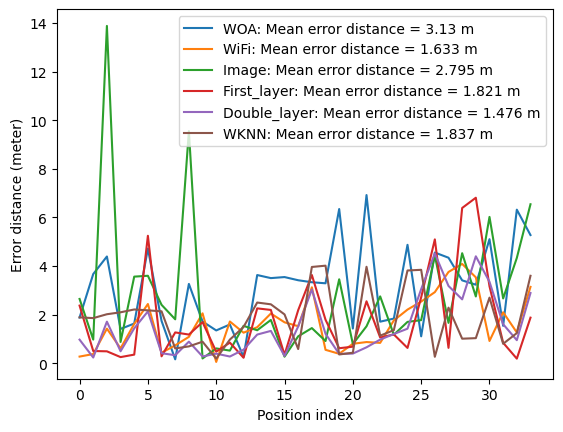

In [18]:
plt.plot(result_list['WOA_error_distance'])
plt.plot(result_list['WiFi_error_distance'])
plt.plot(result_list['Image_error_distance'])
plt.plot(result_list['First_layer_error_distance'])
plt.plot(result_list['Double_layer_error_distance'])
plt.plot(result_list['WKNN_error_distance'])
plt.xlabel('Position index')
plt.ylabel('Error distance (meter)')
plt.legend(['WOA: Mean error distance = '+str(round(result_list['WOA_error_distance'].mean(),3))+' m',
            'WiFi: Mean error distance = '+str(round(result_list['WiFi_error_distance'].mean(),3))+' m',
            'Image: Mean error distance = '+str(round(result_list['Image_error_distance'].mean(),3))+' m',
            'First_layer: Mean error distance = '+str(round(result_list['First_layer_error_distance'].mean(),3))+' m',
            'Double_layer: Mean error distance = '+str(round(result_list['Double_layer_error_distance'].mean(),3))+' m',
            'WKNN: Mean error distance = '+str(round(result_list['WKNN_error_distance'].mean(),3))+' m'])

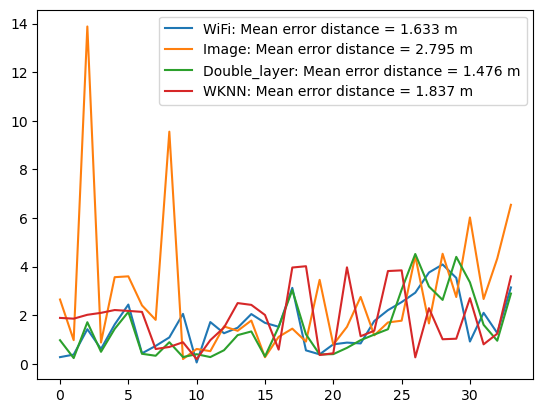

In [19]:
plt.plot(result_list['WiFi_error_distance'])
plt.plot(result_list['Image_error_distance'])
plt.plot(result_list['Double_layer_error_distance'])
plt.plot(result_list['WKNN_error_distance'])

plt.legend(['WiFi: Mean error distance = '+str(round(result_list['WiFi_error_distance'].mean(),3))+' m',
            'Image: Mean error distance = '+str(round(result_list['Image_error_distance'].mean(),3))+' m',
            'Double_layer: Mean error distance = '+str(round(result_list['Double_layer_error_distance'].mean(),3))+' m',
            'WKNN: Mean error distance = '+str(round(result_list['WKNN_error_distance'].mean(),3))+' m'])

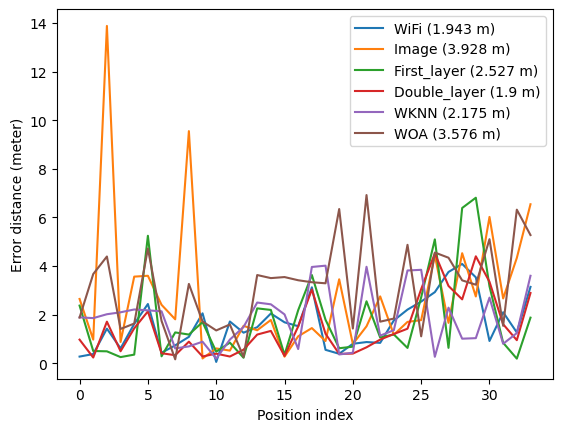

In [20]:
plt.plot(result_list['WiFi_error_distance'])
plt.plot(result_list['Image_error_distance'])
plt.plot(result_list['First_layer_error_distance'])
plt.plot(result_list['Double_layer_error_distance'])
plt.plot(result_list['WKNN_error_distance'])
plt.plot(result_list['WOA_error_distance'])
plt.xlabel('Position index')
plt.ylabel('Error distance (meter)')
plt.legend(['WiFi ('+str(round(result_list['WiFi_RMSE'].mean(),3))+' m)',
            'Image ('+str(round(result_list['Image_RMSE'].mean(),3))+' m)',
            'First_layer ('+str(round(result_list['First_layer_RMSE'].mean(),3))+' m)',

            'Double_layer ('+str(round(result_list['Double_layer_RMSE'].mean(),3))+' m)',

            'WKNN ('+str(round(result_list['WKNN_RMSE'].mean(),3))+' m)',
            'WOA ('+str(round(result_list['WOA_RMSE'].mean(),3))+' m)',])
#plt.title("Image resolution: 116x116")

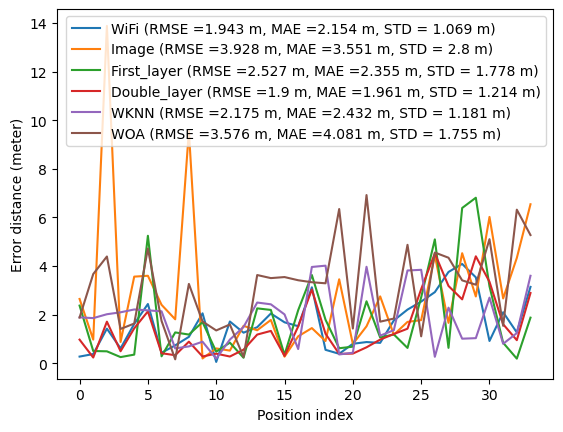

In [21]:
plt.plot(result_list['WiFi_error_distance'])
plt.plot(result_list['Image_error_distance'])
plt.plot(result_list['First_layer_error_distance'])
plt.plot(result_list['Double_layer_error_distance'])
plt.plot(result_list['WKNN_error_distance'])
plt.plot(result_list['WOA_error_distance'])
plt.xlabel('Position index')
plt.ylabel('Error distance (meter)')



plt.legend(['WiFi (RMSE ='+ str(round(result_list['WiFi_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['WiFi_MAE'].mean(),3))+' m, STD = '+ str(round(result_list['WiFi_error_distance'].std(),3))+ ' m)',
            
            'Image (RMSE ='+ str(round(result_list['Image_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['Image_MAE'].mean(),3))+' m, STD = '+ str(round(result_list['Image_error_distance'].std(),3))+ ' m)',
            
            'First_layer (RMSE ='+ str(round(result_list['First_layer_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['First_layer_MAE'].mean(),3))+' m, STD = '+ 
            str(round(result_list['First_layer_error_distance'].std(),3))+ ' m)',
            
            
            'Double_layer (RMSE ='+ str(round(result_list['Double_layer_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['Double_layer_MAE'].mean(),3))+' m, STD = '+ 
            str(round(result_list['Double_layer_error_distance'].std(),3))+ ' m)',

 
            
            'WKNN (RMSE ='+ str(round(result_list['WKNN_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['WKNN_MAE'].mean(),3))+' m, STD = '+
            str(round(result_list['WKNN_error_distance'].std(),3))+ ' m)',
           
            'WOA (RMSE ='+ str(round(result_list['WOA_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['WOA_MAE'].mean(),3))+' m, STD = '+
            str(round(result_list['WOA_error_distance'].std(),3))+ ' m)'])


In [22]:
result_list['Double_layer_error_distance'].std()

1.213809518787425

In [23]:
result_list['First_layer_error_distance'].std()

1.7778992330408756

In [24]:
result_list.columns

Index(['WiFi', 'First_layer', 'Double_layer', 'Image', 'WKNN', 'WOA',
       'True position', 'WiFi_error_distance', 'First_layer_error_distance',
       'Double_layer_error_distance', 'Image_error_distance',
       'WKNN_error_distance', 'WOA_error_distance', 'First_layer_RMSE',
       'Double_layer_RMSE', 'WiFi_RMSE', 'Image_RMSE', 'WOA_RMSE', 'WKNN_RMSE',
       'First_layer_MAE', 'Double_layer_MAE', 'WiFi_MAE', 'Image_MAE',
       'WOA_MAE', 'WKNN_MAE'],
      dtype='object')

# Table

In [25]:
Table = []
for m in result_list.columns[0:6]:
    a = {}
    a['Method'] = m
    a['Mean error distance'] = round(result_list[m+'_error_distance'].mean(),3)    
    a['RMSE'] = round(result_list[m+'_RMSE'].mean(),3)
    a['MAE'] = round(result_list[m+'_MAE'].mean(),3)
    a['Std'] = round(result_list[m+'_error_distance'].std(),3)  
    Table.append(a)
    

In [26]:
pd.DataFrame(Table)

,Method,Mean error distance,RMSE,MAE,Std
0,WiFi,1.633,1.943,2.154,1.069
1,First_layer,1.821,2.527,2.355,1.778
2,Double_layer,1.476,1.900,1.961,1.214
3,Image,2.795,3.928,3.551,2.800
4,WKNN,1.837,2.175,2.432,1.181
5,WOA,3.130,3.576,4.081,1.755


# CDF

In [27]:
a = list(np.arange(0,15,0.1))

counts_wifi, bins = np.histogram(result_list['WiFi_error_distance'], bins=a)
cumulative_wifi = np.cumsum(counts_wifi).astype(np.float64)
cumulative_wifi /= cumulative_wifi[-1]

counts_image, bins = np.histogram(result_list['Image_error_distance'], bins=a)
cumulative_image = np.cumsum(counts_image).astype(np.float64)
cumulative_image /= cumulative_image[-1]


counts_first_layer, bins = np.histogram(result_list['First_layer_error_distance'], bins=a)
cumulative_first_layer = np.cumsum(counts_first_layer).astype(np.float64)
cumulative_first_layer /= cumulative_first_layer[-1]


counts_double_layer, bins = np.histogram(result_list['Double_layer_error_distance'], bins=a)
cumulative_double_layer = np.cumsum(counts_double_layer).astype(np.float64)
cumulative_double_layer /= cumulative_double_layer[-1]


counts_WKNN, bins = np.histogram(result_list['WKNN_error_distance'], bins=a)
cumulative_WKNN = np.cumsum(counts_WKNN).astype(np.float64)
cumulative_WKNN /= cumulative_WKNN[-1]



counts_WOA, bins = np.histogram(result_list['WOA_error_distance'], bins=a)
cumulative_WOA = np.cumsum(counts_WOA).astype(np.float64)
cumulative_WOA /= cumulative_WOA[-1]

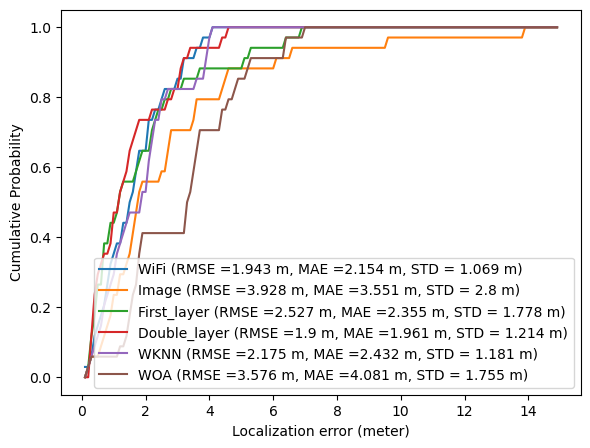

In [28]:
# CDF
plt.figure(figsize= (6.7,5))
plt.plot(bins[1::], cumulative_wifi)
plt.plot(bins[1::], cumulative_image)
plt.plot(bins[1::], cumulative_first_layer)
plt.plot(bins[1::], cumulative_double_layer)
plt.plot(bins[1::], cumulative_WKNN)
plt.plot(bins[1::], cumulative_WOA)



plt.xlabel('Localization error (meter)')
plt.ylabel('Cumulative Probability')
# plt.title('Cumulative Distribution Function')
plt.legend(['WiFi (RMSE ='+ str(round(result_list['WiFi_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['WiFi_MAE'].mean(),3))+' m, STD = '+ str(round(result_list['WiFi_error_distance'].std(),3))+ ' m)',
            
            'Image (RMSE ='+ str(round(result_list['Image_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['Image_MAE'].mean(),3))+' m, STD = '+ str(round(result_list['Image_error_distance'].std(),3))+ ' m)',
            
            
            'First_layer (RMSE ='+ str(round(result_list['First_layer_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['First_layer_MAE'].mean(),3))+' m, STD = '+ 
            str(round(result_list['First_layer_error_distance'].std(),3))+ ' m)',            
            
            
            'Double_layer (RMSE ='+ str(round(result_list['Double_layer_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['Double_layer_MAE'].mean(),3))+' m, STD = '+ 
            str(round(result_list['Double_layer_error_distance'].std(),3))+ ' m)',
            
            
            'WKNN (RMSE ='+ str(round(result_list['WKNN_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['WKNN_MAE'].mean(),3))+' m, STD = '+ str(round(result_list['WKNN_error_distance'].std(),3))+ ' m)',
  
            
            'WOA (RMSE ='+ str(round(result_list['WOA_RMSE'].mean(),3))+' m, MAE ='+ 
            str(round(result_list['WOA_MAE'].mean(),3))+' m, STD = '+
            str(round(result_list['WOA_error_distance'].std(),3))+ ' m)'])


plt.show()